In [ ]:
from pathlib import Path
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import pdb
import pickle
import numpy as np
from typing_extensions import Annotated
import time

from mbnpy import model, config, trans, variable, brc, branch, cpm, operation

HOME = Path().resolve()

%matplotlib inline

# User inputs

System event definition

In [2]:
key = 'od1'
thres = 5 # if it takes longer than this, we consider the od pair is disconnected

Configuation data

In [3]:
# load data
cfg = config.Config(HOME.joinpath('./config.json'))
od_pair = cfg.infra['ODs'][key]

scenario to be added later


Failure probabilities of each bridge (modelled as nodes in the graph)

Here we assume binary states for each edge, assuming that 
connectivity is the most concerned factor for emergency activities
i.e. congestion is not of concern

In [4]:
# for temporary purpose; will be replaced with actual probability data
rnd_state = np.random.RandomState(1) 

probs_set = {0: {0: 0.05, 1: 0.95},
                1: {0: 0.15, 1: 0.85},
                2: {0: 0.30, 1: 0.70},
                }
probs_key = rnd_state.choice(3, size=len(cfg.infra['edges']))

# Here, we assume 
probs = {k: [probs_set[v][0], probs_set[v][1]]for k, v in zip(cfg.infra['nodes'].keys(), probs_key)}
print(probs)

{'Wooroloo': [0.15, 0.85], 'Merredin': [0.05, 0.95], '0277': [0.05, 0.95], '0278': [0.15, 0.85], '0279': [0.15, 0.85], '0280': [0.05, 0.95], '0281': [0.05, 0.95], '0282': [0.15, 0.85], '0283': [0.05, 0.95], '0284': [0.15, 0.85], '0285': [0.05, 0.95], '0286': [0.3, 0.7], '0287': [0.15, 0.85], '0288': [0.3, 0.7], '0289': [0.05, 0.95], '0290': [0.3, 0.7], '0291': [0.15, 0.85], '0299': [0.3, 0.7], '0300': [0.05, 0.95], '0301': [0.05, 0.95], '0302': [0.3, 0.7], '0303': [0.05, 0.95], '0304': [0.15, 0.85], '0305': [0.3, 0.7], '0361': [0.3, 0.7], '0574': [0.05, 0.95], '0576': [0.15, 0.85], '0579': [0.15, 0.85], '0580': [0.3, 0.7], '0589': [0.05, 0.95], '0592': [0.3, 0.7], '0596': [0.15, 0.85], '0597': [0.15, 0.85], '0598': [0.15, 0.85], '0602': [0.15, 0.85], '0606': [0.3, 0.7], '0612': [0.15, 0.85], '0613': [0.15, 0.85], '0617': [0.05, 0.95], '0627': [0.05, 0.95], '0628': [0.15, 0.85], '0631A': [0.05, 0.95], '0632A': [0.05, 0.95], '0633A': [0.15, 0.85], '0634': [0.3, 0.7], '0637': [0.15, 0.85]

# Modelling

The Bayesian network consists of three layers, each representing bridges, paths, and the system. <br>
The system event represents the time it takes from origin to destination.

<img src='BN.jpeg' alt='BN graph' width='750' />

Component events

In [5]:
# variables
varis = {}
cpms = {}
for k, v in cfg.infra['nodes'].items():
    varis[k] = variable.Variable(name=k, values = ['f', 's'])
    cpms[k] = cpm.Cpm(variables = [varis[k]], no_child=1,
                        C = np.array([0, 1]).T, p = [probs[k][0], probs[k][1]])

Network analysis

In [6]:
G = cfg.infra['G']
d_time_itc = nx.shortest_path_length(G, source=od_pair[0], target=od_pair[1], weight='weight')
print(d_time_itc)

893


In [7]:
valid_paths = []
all_paths = nx.all_simple_paths(G, od_pair[0], od_pair[1])

for path in all_paths:
    # Calculate the total weight of the path
    path_edges = [(u, v) for u, v in zip(path[:-1], path[1:])]
    path_weight = sum(G[u][v]['weight'] for u, v in path_edges)
    
    if path_weight < thres * d_time_itc: # select paths that are shorter than thres * d_time_itc
        edge_names = [G[u][v].get('key', (u, v)) for u, v in path_edges]
        valid_paths.append((path, edge_names, path_weight))

# Sort valid paths by weight
valid_paths = sorted(valid_paths, key=lambda x: x[2])

# Print the paths with edge names and weights
for path, edge_names, weight in valid_paths:
    print(f"Path (nodes): {path}")
    print(f"Path (edges): {edge_names}")
    print(f"Total weight: {weight}\n")

Path (nodes): ['Wooroloo', '0361', 'Merredin']
Path (edges): ['66', '67']
Total weight: 893

Path (nodes): ['Wooroloo', '4815', '4154', '4156', 'Merredin']
Path (edges): ['95', '96', '97', '98']
Total weight: 1342

Path (nodes): ['Wooroloo', '0289', '0288', '0287', '0286', '0285', '0284', '0283', '0282', '0281', '0280', '0279', '0278', '0277', 'Merredin']
Path (edges): ['76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89']
Total weight: 1442

Path (nodes): ['Wooroloo', '0752', '0753', '0754', '0761', '0762', '0763A', '0765', 'Merredin']
Path (edges): ['68', '69', '70', '71', '72', '73', '74', '75']
Total weight: 3251



System event modelling (1/2): individual valid paths

In [8]:
path_names = []
for idx, (path, edge_names, weight) in enumerate(valid_paths):
    name = od_pair[0] + '_' + od_pair[1] + '_' + str(idx)
    path_names.append(name)

    varis[name] = variable.Variable(name=name, values = [np.inf, weight])

    n_child = len(path)

    # Event matrix of series system
    # Initialize an array of shape (n+1, n+1) filled with 1
    Cpath = np.ones((n_child + 1, n_child+1), dtype=int)
    # Fill the diagonal below the main diagonal with 0
    for i in range(1, n_child + 1):
        Cpath[i, 0] = 0
        Cpath[i, i] = 0  
    # Fill the lower triangular part (excluding the diagonal) with 2
    for i in range(1, n_child + 1):
        Cpath[i, i+1:] = 2
    ppath = np.array([1.0]*(n_child+1))

    cpms[name] = cpm.Cpm(variables = [varis[name]] + [varis[n] for n in path], no_child=1, C=Cpath, p=ppath)

print(cpms[name])


Cpm(
    variables=['Wooroloo_Merredin_3', 'Wooroloo', '0752', '0753', '0754', '0761', '0762', '0763A', '0765', 'Merredin'],
    no_child=1,
    C=[[1 1 1 1 1 1 1 1 1 1]
 [0 0 2 2 2 2 2 2 2 2]
 [0 1 0 2 2 2 2 2 2 2]
 [0 1 1 0 2 2 2 2 2 2]
 [0 1 1 1 0 2 2 2 2 2]
 [0 1 1 1 1 0 2 2 2 2]
 [0 1 1 1 1 1 0 2 2 2]
 [0 1 1 1 1 1 1 0 2 2]
 [0 1 1 1 1 1 1 1 0 2]
 [0 1 1 1 1 1 1 1 1 0]],
    p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]],
)


System event modelling (1/2): system event as a series system of the valid paths

In [9]:
od_name = od_pair[0] + '_' + od_pair[1]
vals = [np.inf]
for p in path_names[::-1]:
    vals.append(varis[p].values[1])

n_path = len(path_names)
Csys = np.zeros((n_path+1, n_path+1), dtype=int)
for i in range(n_path):
    Csys[i, 0] = n_path - i
    Csys[i, i+1] = 1
    Csys[i, i+2:] = 2
psys = np.array([1.0]*(n_path+1))

varis[od_name] = variable.Variable(name=od_name, values = vals)
cpms[od_name] = cpm.Cpm(variables = [varis[od_name]] + [varis[p] for p in path_names], no_child=1, C=Csys, p=psys)

print(cpms[od_name])

Cpm(
    variables=['Wooroloo_Merredin', 'Wooroloo_Merredin_0', 'Wooroloo_Merredin_1', 'Wooroloo_Merredin_2', 'Wooroloo_Merredin_3'],
    no_child=1,
    C=[[4 1 2 2 2]
 [3 0 1 2 2]
 [2 0 0 1 2]
 [1 0 0 0 1]
 [0 0 0 0 0]],
    p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]],
)


Save the results

In [10]:
fcpms = cfg.output_path.joinpath('cpms.pk')
with open(fcpms, 'wb') as f:
    pickle.dump(cpms, f)

fvaris = cfg.output_path.joinpath('varis.pk')
with open(fvaris, 'wb') as f:
    pickle.dump(varis, f)

# Inference

Load data

In [11]:
cpms = pickle.load(open(fcpms, 'rb'))
varis = pickle.load(open(fvaris, 'rb'))
cfg = config.Config(HOME.joinpath('./config.json'))


scenario to be added later


## System event

In [12]:
od_pair = cfg.infra['ODs']['od1']

VE_ord = list(probs.keys()) + path_names
vars_inf = operation.get_inf_vars( cpms, od_name, VE_ord )


In [13]:
od_name = od_pair[0] + '_' + od_pair[1]

start = time.time()
# CPM of the od_pair system event
Mod = operation.variable_elim([cpms[k] for k in vars_inf], [v for v in vars_inf if v!=od_name]) 
end = time.time()

print('Time elapsed: ', end - start)
print(Mod)


Time elapsed:  85.02551937103271
Cpm(
    variables=['Wooroloo_Merredin'],
    no_child=1,
    C=[[0]
 [4]
 [3]
 [2]
 [1]],
    p=[[0.24837241]
 [0.56525   ]
 [0.13693181]
 [0.016832  ]
 [0.03261378]],
)


Visualisation

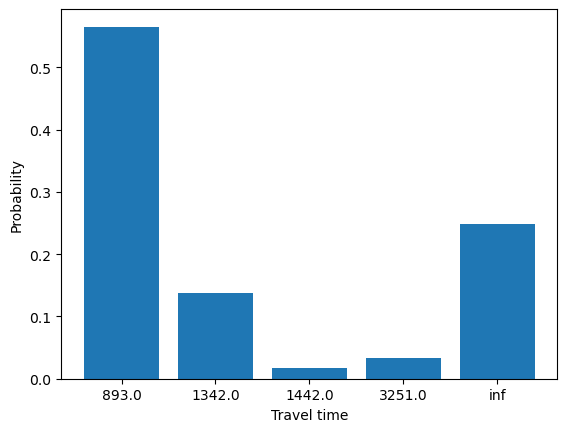

In [14]:
Mod.sort()

plt.figure()
p_flat = Mod.p.flatten()
plt.bar(range(len(p_flat)), p_flat[::-1], tick_label=varis[od_name].values[::-1])

plt.xlabel("Travel time")
plt.ylabel("Probability")

plt.show()

## Routes

In [15]:
paths_name = [v.name for v in cpms[od_name].variables[1:]]
print(paths_name)

['Wooroloo_Merredin_0', 'Wooroloo_Merredin_1', 'Wooroloo_Merredin_2', 'Wooroloo_Merredin_3']


In [16]:
paths_rel = []
for path_i in paths_name:
    VE_ord = list(probs.keys()) + path_names
    vars_inf = operation.get_inf_vars( cpms, path_i, VE_ord )

    Mpath = operation.variable_elim([cpms[k] for k in vars_inf], [v for v in vars_inf if v!=path_i]) 
    paths_rel.append( Mpath.p[1][0] )

print(paths_rel)

[0.5652499999999999, 0.4564393749999999, 0.12905501075266862, 0.29762414721484376]


Visualisation

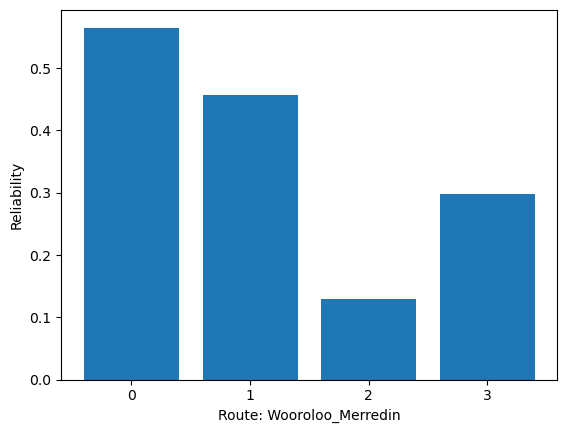

In [17]:
plt.figure()
p_flat = Mod.p.flatten()
plt.bar(range(len(paths_rel)), paths_rel, tick_label=range(len(paths_rel)))

plt.xlabel(f"Route: {od_name}")
plt.ylabel("Reliability")

plt.show()